# Libs

In [1]:

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

import numpy as np

import os
import re
import sys

import math

import seaborn as sns

import pickle
 
from collections import defaultdict
    
sys.path.append("/home/charles/Projects/BarycentersAgePyramid/Python")
sys.path.append("/home/dhw3172/projects/barycenterAgePyramid/Python")

from WassAge import *

from pathlib import Path

/home/charles/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Params

In [2]:
DATA_PATH = Path("." ) / ".." / ".." / "Data" 
os.listdir(DATA_PATH)

['Numpy',
 'shpMtlDAAgePyramid',
 'QuebecNeighbourhoods',
 '.ipynb_checkpoints',
 'MontrealNeighbourhoods',
 'shpQcDAAgePyramid',
 'Extremal']

In [3]:
np.random.seed(1)

In [4]:
useApproxWass= False
approxStr = "Exact" if useApproxWass else "Approximate"

In [5]:
city="Montreal"
#city="Quebec City"

# Data IO

## Load back the city-wide wass barycenter + DA shp

In [6]:
def readBackWass(city):
    dfGeoClean = normalizeCleanDfGeo( readDAShp(city=city) )
    dfGeoCleanAge = dfGeoClean[LIST_AGE_COLS]
    
    subsetRows= dfGeoClean.shape[0] if city == "Quebec City" else 900
    with open(Path(".") /".." / ".." / "Data" / "Numpy" / f"cityWideDAWassBarycenter_{subsetRows}_{city}.pickle", "rb") as f:
        bary_wass=pickle.load( f )
        
    return bary_wass, dfGeoCleanAge, dfGeoClean

In [7]:
dictWass=defaultdict(str)
dictGeoClean=defaultdict(str)
dictGeo=defaultdict(str)

for n in ["Quebec City" , "Montreal"]:
    w,dclean,d=readBackWass(n)
    dictWass[n] = w / np.sum(w)          #might be small scaling errors => make sure sum is really 1
    dictGeoClean[n] = dclean
    dictGeo[n] = d

Reading neibourhoods from Quebec City
Reading neibourhoods from Montreal


# Evaluate departure from reference egalitarian distribution with all weight equal

## Reference distribution: mass of 1/n

In [8]:
youngRefDist = np.zeros( shape=(len(getAgeRepresentativeArray()),))
youngRefDist[0]=1
youngRefDist.shape
np.sum(youngRefDist)

1.0

# Util to get finer age bins

In [25]:

def getAgeArray(numBreak=NUM_AGE_BINS ):


    minAge=getAgeRepresentativeArray()[0,0]
    maxAge = getAgeRepresentativeArray()[NUM_AGE_BINS-1,0]
    step=(((maxAge)-minAge)/numBreak)

    ageArray = np.linspace(minAge,maxAge,num=numBreak,endpoint=True).astype(int)
    ageArray=ageArray.reshape(-1,1)

    return ageArray, numBreak, step

## Distance matrix from age bin centroids

In [61]:
def getAgeDist(ageArray):
    ageDist=np.ones_like(ageArray)/len(ageArray)
    
    return ageDist.ravel()

In [62]:
def getDistMatAge(ageArray):
    distMat = distance_matrix(getAgeRepresentativeArray(),ageArray)
    distMat= distMat / np.max( distMat)
    
    return distMat

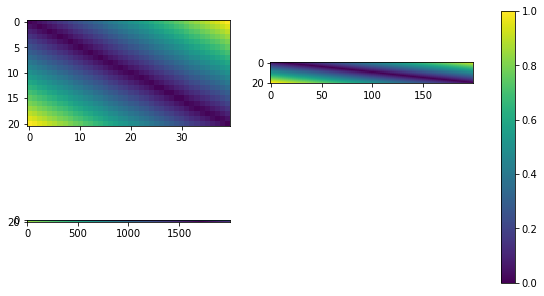

In [49]:
f=plt.figure(figsize=(10,5))
listAx=[]

for i, v in enumerate([40,200,2000]):
    
    ax=plt.subplot(2,2,i+1)
    listAx.append(ax)
    

    ageArray , _ , _= getAgeArray(v)


    distMat = getDistMatAge(ageArray)
    plt.imshow(distMat)
    
    
plt.colorbar(ax=listAx)

## Compute EMD

In [77]:
dictDictOptTransport=defaultdict(int)
dictDictDist=defaultdict(int)

for i, v in enumerate([21,200,2000]):
    
    dictOptTransport=defaultdict(str)
    dictDist=defaultdict(str)

    dictDictOptTransport[v]=dictOptTransport
    dictDictDist[v]=dictDist
    
    ageArray , _ , _= getAgeArray(v)
    distMat = getDistMatAge(ageArray)
    ageDist=getAgeDist(ageArray) 
    
    for n in ["Quebec City" , "Montreal"]:

        optT =ot.lp.emd(dictWass[n], ageDist  ,distMat)

        dictOptTransport[n] = optT
        dictDist[n] = np.sum( optT[:] * distMat[:])

In [64]:
dictDictDist

defaultdict(int,
            {40: defaultdict(str,
                         {'Quebec City': 0.0924998106814877,
                          'Montreal': 0.11729034669116534}),
             200: defaultdict(str,
                         {'Quebec City': 0.08985554063387508,
                          'Montreal': 0.1170903466911653}),
             2000: defaultdict(str,
                         {'Quebec City': 0.08981054063387466,
                          'Montreal': 0.11704534669116491})})

In [80]:
listIndex=[ int( np.quantile(range(len(LIST_AGE_COLS)), i/9)) for i in range(10) ]
listAgeSubset = np.array(LIST_AGE_COLS)[listIndex]

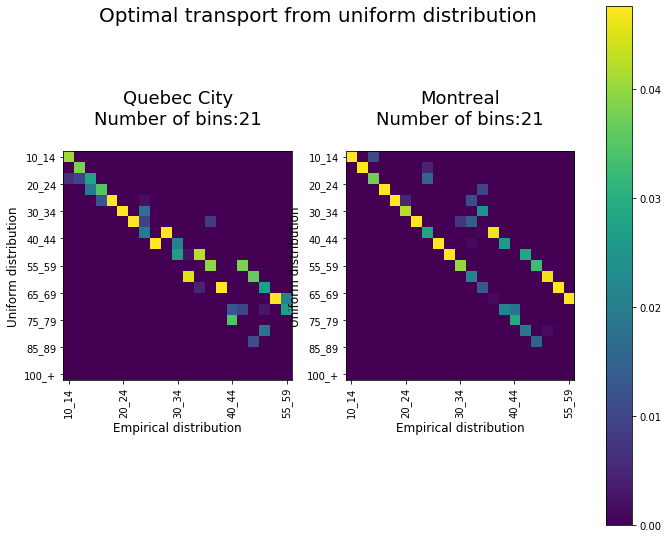

In [143]:
fig=plt.figure(figsize=(15,15))
fig.suptitle("Optimal transport from uniform distribution", fontsize=20,ha="right")
listSp=[]
for i, v in enumerate([21]):
    for j,n in enumerate(["Quebec City" , "Montreal"]):
        
        sp=plt.subplot(2,3,2*i+j+1)
        listSp.append(sp)
        sp.set_title(f"{n}\nNumber of bins:{v}\n", fontsize=18)
        plt.imshow(dictDictOptTransport[v][n])
        
        plt.xticks(rotation=90)
        sp.set_xticklabels(labels=listAgeSubset)
        sp.set_yticklabels(labels=listAgeSubset)
        
        sp.set_xlabel("Empirical distribution", fontsize=12)
        sp.set_ylabel("Uniform distribution", fontsize=12)
        


fig.tight_layout( rect=[0, 0, 0.99, 0.99])
plt.colorbar(ax=listSp)
fig.savefig( Path(DATA_PATH) /".."/ "Figures" / "ReferenceDistributions"  / f"wassUniformDist.png")

## Compare cost


In [144]:
dfDist=pd.DataFrame.from_dict(dictDictDist[21], columns=['distance'] , orient='index').reset_index()
dfDist.rename(columns={"index":"city"},inplace=True)
dfDist

city  distance
0  Quebec City  0.097567
1     Montreal  0.122040

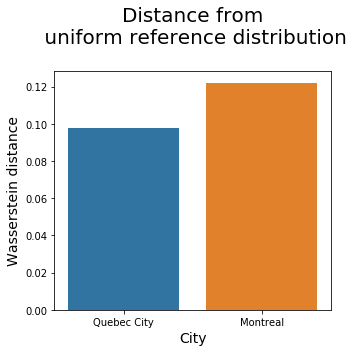

In [146]:
fig = plt.figure(figsize=(5,5))

ax = sns.barplot(x="city", y="distance"  ,data=dfDist)
ax.set_title("Distance from\n uniform reference distribution\n", fontsize=20)
ax.set_xlabel('City',fontsize=14);
ax.set_ylabel('Wasserstein distance',fontsize=14);


plt.tight_layout(rect=[0, 0, 1, 1])

fig.savefig( Path(DATA_PATH) /".."/ "Figures" / "ReferenceDistributions"  / f"wassDistFromUniformDist.png")